In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MultiHeadAttention
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the model from the H5 file
loaded_model = load_model('vgg16_model.h5')

# Print the shape of the feature extraction layer for debugging
print("Feature Shape:", loaded_model.layers[-3].output_shape[1:])

Feature Shape: (64,)


In [3]:
train_path = './train'
test_path = './test'
val_path = './val'

size_images = 150
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
)
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 31571 images belonging to 4 classes.
Found 6769 images belonging to 4 classes.
Found 6765 images belonging to 4 classes.


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

# Use the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
# Assuming you have a pre-trained feature extractor model (e.g., a CNN)
pretrained_feature_extractor = loaded_model.layers[-3]

# Get the output shape of the feature extraction layer
feature_shape = pretrained_feature_extractor.output_shape[1:]

base_model = models.Model(inputs=loaded_model.input, outputs=loaded_model.layers[-3].output)
# Print the shape for debugging
print("Feature Shape:", feature_shape)

Feature Shape: (64,)


In [7]:
# Define your transformer model
def transformer_model(input_shape, num_transformer_layers, output_dim):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Add a "sequence_length" dimension to the input
    sequence = layers.Reshape((1, input_shape[0]))(inputs)
    
    # Transformer layers using MultiHeadAttention
    sequence = MultiHeadAttention(num_heads=5, key_dim=64)(sequence, sequence)
    sequence = layers.LayerNormalization(epsilon=1e-6)(sequence)
    sequence = layers.Dropout(0.1)(sequence)
    
    # Reshape the sequence to maintain 3D structure
    sequence = layers.Reshape((-1, feature_shape[0]))(sequence)
    
    # Output layer for your specific task
    outputs = layers.Dense(output_dim, activation='softmax')(sequence)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Define your task-specific output dimension (e.g., number of classes)
output_dim = 4
num_tlayers = 2

# Create the transformer model
transformer = transformer_model(input_shape=feature_shape, num_transformer_layers=num_tlayers, output_dim=output_dim)

# Print the summary of the model for debugging
transformer.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 64)        0           input_1[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 1, 64)        82944       reshape[0][0]                    
                                                                 reshape[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 1, 64)        128         multi_head_attention[0][0] 

In [8]:
# Combine the pre-trained feature extractor with the transformer
combined_model = models.Sequential([
    base_model,
    transformer,
    layers.Flatten()  # Add Flatten layer to reshape the output
])

# Compile the model (adjust loss and metrics based on your task)
combined_model.compile(optimizer=Adam(learning_rate=0.000005), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the combined model
combined_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 64)                16853248  
_________________________________________________________________
model_1 (Functional)         (None, 1, 4)              83332     
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
Total params: 16,936,580
Trainable params: 2,221,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# Train the model
import math
history = combined_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/20
986/986 [==============================] - 485s 486ms/step - loss: 0.1329 - accuracy: 0.9547 - val_loss: 0.1743 - val_accuracy: 0.9510
Epoch 2/20
986/986 [==============================] - 169s 171ms/step - loss: 0.1050 - accuracy: 0.9628 - val_loss: 0.1620 - val_accuracy: 0.9434
Epoch 3/20
986/986 [==============================] - 170s 173ms/step - loss: 0.0986 - accuracy: 0.9661 - val_loss: 0.1758 - val_accuracy: 0.9431
Epoch 4/20
986/986 [==============================] - 171s 173ms/step - loss: 0.0928 - accuracy: 0.9685 - val_loss: 0.1877 - val_accuracy: 0.9437
Epoch 5/20
986/986 [==============================] - 173s 175ms/step - loss: 0.0523 - accuracy: 0.9830 - val_loss: 0.1775 - val_accuracy: 0.9485
Epoch 6/20
986/986 [==============================] - 169s 171ms/step - loss: 0.0478 - accuracy: 0.9835 - val_loss: 0.1690 - val_accuracy: 0.9556
Epoch 7/20
986/986 [==============================] - 167s 169ms/step - loss: 0.0430 - accuracy: 0.9856 - val_loss: 0.1557 -

In [10]:
test_results = combined_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

211/211 [==============================] - 31s 144ms/step - loss: 0.1825 - accuracy: 0.9553
Test Loss: 0.1824849247932434
Test Accuracy: 0.9552724957466125


In [ ]:
combined_model.save('vgg16_vit_model.h5')

In [14]:
import numpy as np

# Initialize lists to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Loop through all batches in the test generator
for _ in range(len(test_generator)):
    images, labels = test_generator.next()

    # Predictions on the current batch
    batch_predictions = combined_model.predict(images)
    all_predictions.extend(batch_predictions)
    
    # True labels for the current batch
    batch_true_labels = np.argmax(labels, axis=1)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Extract predicted labels from all predictions
predicted_labels = np.argmax(all_predictions, axis=1)

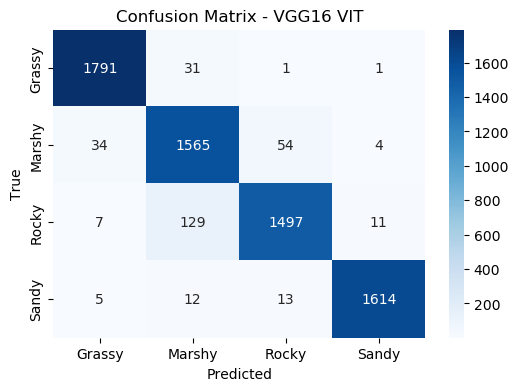

In [18]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(all_true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - VGG16 VIT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# Calculate percentage of correct predictions for each class
correctly_classified = np.diag(conf_mat)
total_true_per_class = np.sum(conf_mat, axis=1)
percentage_correct_per_class = (correctly_classified / total_true_per_class) * 100

# Display the percentage of correct predictions for each class
for i, class_name in enumerate(class_names):
    print(f'Percentage of correct predictions for {class_name}: {percentage_correct_per_class[i]:.2f}%')


Percentage of correct predictions for Grassy: 98.19%
Percentage of correct predictions for Marshy: 94.45%
Percentage of correct predictions for Rocky: 91.06%
Percentage of correct predictions for Sandy: 98.18%


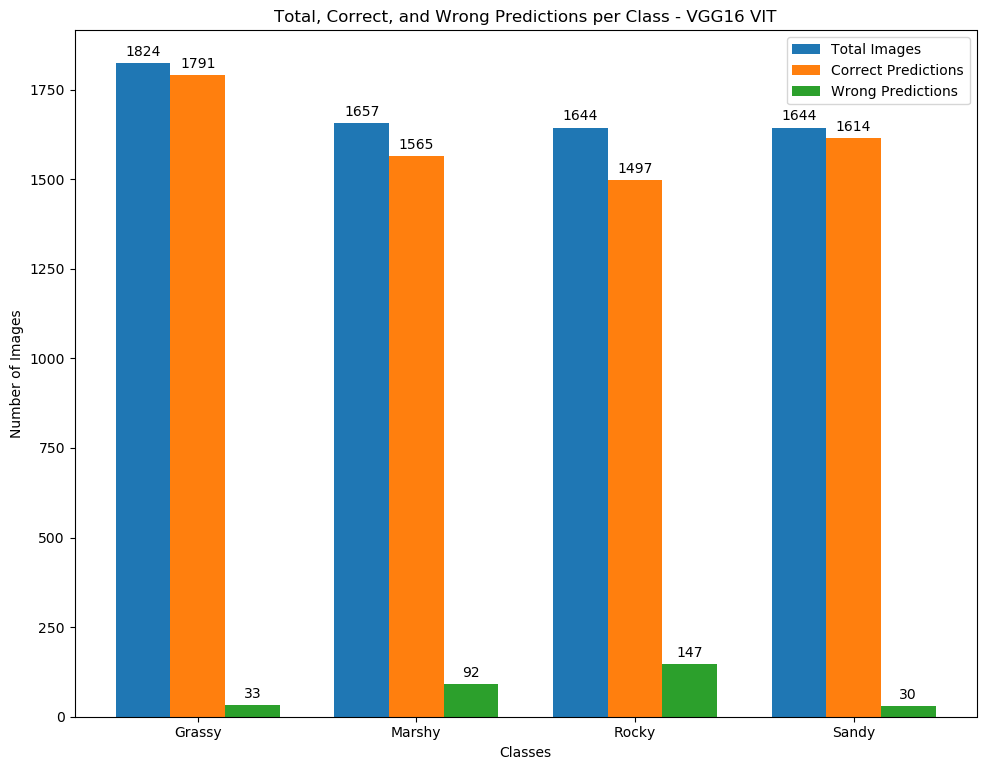

In [17]:
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names

# Print the number of images classified correctly and wrongly in each class
correctly_classified = np.diag(conf_mat)
wrongly_classified = np.sum(conf_mat, axis=1) - correctly_classified

# Total number of images in each class
total_images_per_class = np.sum(conf_mat, axis=1)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_images_per_class, width, label='Total Images')
rects2 = ax.bar(x, correctly_classified, width, label='Correct Predictions')
rects3 = ax.bar(x + width, wrongly_classified, width, label='Wrong Predictions')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Total, Correct, and Wrong Predictions per Class - VGG16 VIT')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Display the number of images on top of each bar with proper spacing
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 1.3])  # Increase the value in the last argument if necessary

plt.show()

In [1]:
import numpy as np

def calculate_metrics(confusion_matrix, class_names, total_per_class=None):
  """
  This function calculates and displays various metrics for a 4-class confusion matrix.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix (4x4).
      class_names: A list containing the names of the four classes.
      total_per_class (optional): A list containing the total number of images per class 
                                    (if available). Used to estimate FN_X.

  Returns:
      None (prints the metrics to the console).
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate class-wise accuracy
  class_wise_accuracy = TP / (TP + FP + FN)

  # Calculate total accuracy
  total_accuracy = TP.sum() / confusion_matrix.sum()

  # Macro-average (requires FN_X values)
  if total_per_class is not None:
      # Estimate FN_X if total images per class are provided
      FN = total_per_class - TP

  macro_precision = np.mean(TP / (TP + FP))
  macro_recall = np.mean(TP / (TP + FN)) if total_per_class is not None else np.nan  # Avoid division by zero
  macro_f1 = np.mean(2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)) if total_per_class is not None else np.nan

  # Micro-average
  micro_precision = TP.sum() / (TP.sum() + FP.sum())
  micro_recall = TP.sum() / (TP.sum() + FN.sum()) if total_per_class is not None else np.nan  # Avoid division by zero
  micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

  # Print results
  print("Class-wise Accuracy:")
  for i in range(len(TP)):
    print(f"\t{class_names[i]}: {class_wise_accuracy[i]:.4f}")
  print(f"\nTotal Accuracy: {total_accuracy:.4f}")

  print("\nMacro Average (requires FN values):")
  print(f"\tPrecision: {macro_precision:.4f}")
  print(f"\tRecall: {macro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {macro_f1:.4f}")  # Print NaN if FN_X not available

  print("\nMicro Average:")
  print(f"\tPrecision: {micro_precision:.4f}")
  print(f"\tRecall: {micro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {micro_f1:.4f}")

# Example usage
confusion_matrix = np.array([[1791, 31, 1, 1],
                             [34, 1565, 54, 4],
                             [7, 129, 1497, 11],
                             [5, 12, 13, 1614]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]

# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

calculate_metrics(confusion_matrix, class_names, total_per_class)

# Alternatively, if total images per class are not available
calculate_metrics(confusion_matrix, class_names)


Class-wise Accuracy:
	Grassy: 0.9578
	Marshy: 0.8557
	Rocky: 0.8744
	Sandy: 0.9723

Total Accuracy: 0.9554

Macro Average (requires FN values):
	Precision: 0.9557
	Recall: 0.9547
	F1-Score: 0.9552

Micro Average:
	Precision: 0.9554
	Recall: 0.9554
	F1-Score: 0.9554
Class-wise Accuracy:
	Grassy: 0.9578
	Marshy: 0.8557
	Rocky: 0.8744
	Sandy: 0.9723

Total Accuracy: 0.9554

Macro Average (requires FN values):
	Precision: 0.9557
	Recall: nan
	F1-Score: nan

Micro Average:
	Precision: 0.9554
	Recall: nan
	F1-Score: nan


In [3]:
import numpy as np

def calculate_metrics(confusion_matrix, class_names, total_per_class=None):
  """
  This function calculates and displays various metrics for a 4-class confusion matrix.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix (4x4).
      class_names: A list containing the names of the four classes.
      total_per_class (optional): A list containing the total number of images per class 
                                    (if available). Used to estimate FN_X.

  Returns:
      None (prints the metrics to the console).
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate class-wise metrics
  class_wise_accuracy = TP / (TP + FP + FN)
  class_wise_precision = TP / (TP + FP)
  class_wise_recall = TP / (TP + FN) if total_per_class is not None else np.nan  # Avoid division by zero
  class_wise_f1 = 2 * (class_wise_precision * class_wise_recall) / (class_wise_precision + class_wise_recall) if total_per_class is not None else np.nan

  # Calculate total accuracy
  total_accuracy = TP.sum() / confusion_matrix.sum()

  # Macro-average (requires FN_X values)
  if total_per_class is not None:
      # Estimate FN_X if total images per class are provided
      FN = total_per_class - TP

  macro_precision = np.mean(TP / (TP + FP))
  macro_recall = np.mean(TP / (TP + FN)) if total_per_class is not None else np.nan  # Avoid division by zero
  macro_f1 = np.mean(2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)) if total_per_class is not None else np.nan

  # Micro-average
  micro_precision = TP.sum() / (TP.sum() + FP.sum())
  micro_recall = TP.sum() / (TP.sum() + FN.sum()) if total_per_class is not None else np.nan  # Avoid division by zero
  micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

  # Print results
  print("Class-wise Accuracy:")
  for i in range(len(class_names)):
      # Check if total_per_class is provided, use class-wise metrics otherwise
      if total_per_class is not None:
          print(f"\t{class_names[i]}: Accuracy - {class_wise_accuracy[i]:.4f}, Precision - {class_wise_precision[i]:.4f}, Recall - {class_wise_recall[i]:.4f}, F1-Score - {class_wise_f1[i]:.4f}")
      else:
          print(f"\t{class_names[i]}: Accuracy - {total_accuracy:.4f}")  # Use total accuracy when FN_X not available

  print(f"\nTotal Accuracy: {total_accuracy:.4f}")

  print("\nMacro Average (requires FN values):")
  print(f"\tPrecision: {macro_precision:.4f}")
  print(f"\tRecall: {macro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {macro_f1:.4f}")  # Print NaN


  print("\nMicro Average:")
  print(f"\tPrecision: {micro_precision:.4f}")
  print(f"\tRecall: {micro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {micro_f1:.4f}")

# Example usage
confusion_matrix = np.array([[1791, 31, 1, 1],
                             [34, 1565, 54, 4],
                             [7, 129, 1497, 11],
                             [5, 12, 13, 1614]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]

# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

calculate_metrics(confusion_matrix, class_names, total_per_class)

# Alternatively, if total images per class are not available
calculate_metrics(confusion_matrix, class_names)

Class-wise Accuracy:
	Grassy: Accuracy - 0.9578, Precision - 0.9750, Recall - 0.9819, F1-Score - 0.9784
	Marshy: Accuracy - 0.8557, Precision - 0.9010, Recall - 0.9445, F1-Score - 0.9222
	Rocky: Accuracy - 0.8744, Precision - 0.9565, Recall - 0.9106, F1-Score - 0.9330
	Sandy: Accuracy - 0.9723, Precision - 0.9902, Recall - 0.9818, F1-Score - 0.9859

Total Accuracy: 0.9554

Macro Average (requires FN values):
	Precision: 0.9557
	Recall: 0.9547
	F1-Score: 0.9552

Micro Average:
	Precision: 0.9554
	Recall: 0.9554
	F1-Score: 0.9554
Class-wise Accuracy:
	Grassy: Accuracy - 0.9554
	Marshy: Accuracy - 0.9554
	Rocky: Accuracy - 0.9554
	Sandy: Accuracy - 0.9554

Total Accuracy: 0.9554

Macro Average (requires FN values):
	Precision: 0.9557
	Recall: nan
	F1-Score: nan

Micro Average:
	Precision: 0.9554
	Recall: nan
	F1-Score: nan


In [4]:
import numpy as np

def calculate_metrics(confusion_matrix, class_names, total_per_class=None):
  """
  This function calculates and displays various metrics for a 4-class confusion matrix.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix (4x4).
      class_names: A list containing the names of the four classes.
      total_per_class (optional): A list containing the total number of images per class 
                                    (if available). Used to estimate FN_X.

  Returns:
      None (prints the metrics to the console).
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate class-wise metrics
  class_wise_accuracy = TP / (TP + FP + FN)
  class_wise_precision = TP / (TP + FP)
  if total_per_class is not None:
      # Calculate FN_X if total images per class are provided
      FN_X = total_per_class - TP
      class_wise_recall = TP / FN_X
      class_wise_f1 = 2 * (class_wise_precision * class_wise_recall) / (class_wise_precision + class_wise_recall)
  else:
      class_wise_recall = np.nan  # Avoid division by zero
      class_wise_f1 = np.nan

  # Calculate total accuracy
  total_accuracy = TP.sum() / confusion_matrix.sum()

  # Macro-average (requires FN values)
  if total_per_class is not None:
      macro_precision = np.mean(TP / (TP + FP))
      macro_recall = np.mean(TP / FN_X)
      macro_f1 = np.mean(2 * (macro_precision * macro_recall) / (macro_precision + macro_recall))
  else:
      macro_precision = np.nan
      macro_recall = np.nan
      macro_f1 = np.nan

  # Micro-average
  micro_precision = TP.sum() / (TP.sum() + FP.sum())
  micro_recall = TP.sum() / (TP.sum() + FN.sum()) if total_per_class is not None else np.nan  # Avoid division by zero
  micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

  # Print results
  print("Class-wise Accuracy:")
  for i in range(len(class_names)):
      # Check if total_per_class is provided, use class-wise metrics otherwise
      if total_per_class is not None:
          print(f"\t{class_names[i]}: Accuracy - {class_wise_accuracy[i]:.4f}, Precision - {class_wise_precision[i]:.4f}, Recall - {class_wise_recall[i]:.4f}, F1-Score - {class_wise_f1[i]:.4f}")
      else:
          print(f"\t{class_names[i]}: Accuracy - {total_accuracy:.4f}")  # Use total accuracy when FN_X not available

  print(f"\nTotal Accuracy: {total_accuracy:.4f}")

  print("\nMacro Average (requires FN values):")
  print(f"\tPrecision: {macro_precision:.4f}")
  print(f"\tRecall: {macro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {macro_f1:.4f}")  # Print NaN if FN_X not available

  print("\nMicro Average:")
  print(f"\tPrecision: {micro_precision:.4f}")
  
  # Example usage
confusion_matrix = np.array([[1791, 31, 1, 1],
                             [34, 1565, 54, 4],
                             [7, 129, 1497, 11],
                             [5, 12, 13, 1614]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]

# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

calculate_metrics(confusion_matrix, class_names, total_per_class)

# Alternatively, if total images per class are not available
calculate_metrics(confusion_matrix, class_names)


Class-wise Accuracy:
	Grassy: Accuracy - 0.9578, Precision - 0.9750, Recall - 54.2727, F1-Score - 1.9155
	Marshy: Accuracy - 0.8557, Precision - 0.9010, Recall - 17.0109, F1-Score - 1.7113
	Rocky: Accuracy - 0.8744, Precision - 0.9565, Recall - 10.1837, F1-Score - 1.7488
	Sandy: Accuracy - 0.9723, Precision - 0.9902, Recall - 53.8000, F1-Score - 1.9446

Total Accuracy: 0.9554

Macro Average (requires FN values):
	Precision: 0.9557
	Recall: 33.8168
	F1-Score: 1.8588

Micro Average:
	Precision: 0.9554
Class-wise Accuracy:
	Grassy: Accuracy - 0.9554
	Marshy: Accuracy - 0.9554
	Rocky: Accuracy - 0.9554
	Sandy: Accuracy - 0.9554

Total Accuracy: 0.9554

Macro Average (requires FN values):
	Precision: nan
	Recall: nan
	F1-Score: nan

Micro Average:
	Precision: 0.9554


In [5]:
def generate_classification_report(confusion_matrix, class_names):
  """
  This function generates a classification report string from a confusion matrix.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix.
      class_names: A list containing the names of the classes.

  Returns:
      A string containing the classification report in a common format.
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate totals
  total_support = confusion_matrix.sum(axis=0)  # Total predicted instances per class
  total_ground_truth = confusion_matrix.sum(axis=1)  # Total true instances per class

  # Build the report string
  report = "             Precision    Recall  F1-Score   Support\n"
  for i, class_name in enumerate(class_names):
      precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
      recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
      support = total_predicted_instances = total_support[i]
      report += f"{class_name:14}  {precision:.4f}  {recall:.4f}  {f1:.4f}         {support}\n"

  # Add support for all classes
  report += f"accuracy         {TP.sum() / confusion_matrix.sum():.4f}        {total_ground_truth.sum()}\n"

  return report

# Example usage
confusion_matrix = np.array([[1791, 31, 1, 1],
                             [34, 1565, 54, 4],
                             [7, 129, 1497, 11],
                             [5, 12, 13, 1614]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]
# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

report = generate_classification_report(confusion_matrix, class_names,total_per_class)
print(report)

             Precision    Recall  F1-Score   Support
Grassy          0.9750  0.9819  0.9784         1837
Marshy          0.9010  0.9445  0.9222         1737
Rocky           0.9565  0.9106  0.9330         1565
Sandy           0.9902  0.9818  0.9859         1630
accuracy         0.9554        6769



In [8]:
import numpy as np

def calculate_metrics_and_report(confusion_matrix, class_names, total_per_class):
  """
  This function calculates and displays various metrics and a classification report.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix.
      class_names: A list containing the names of the classes.
      total_per_class (optional): A list containing the total number of images per class 
                                    (if available). Used to estimate FN_X.

  Returns:
      None (prints the metrics and report to the console).
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate totals
  total_support = confusion_matrix.sum(axis=0)  # Total predicted instances per class
  total_ground_truth = confusion_matrix.sum(axis=1)  # Total true instances per class

  # Calculate class-wise accuracy
  class_wise_accuracy = TP / (TP + FP + FN)

  # Macro-average (requires FN values)
  if total_per_class is not None:
      # Estimate FN_X if total images per class are provided
      FN_X = total_per_class - TP
      macro_precision = np.mean(TP / (TP + FP))
      macro_recall = np.mean(TP / FN_X)
      macro_f1 = np.mean(2 * (macro_precision * macro_recall) / (macro_precision + macro_recall))
  else:
      macro_precision = np.nan
      macro_recall = np.nan
      macro_f1 = np.nan

  # Micro-average
  micro_precision = TP.sum() / (TP.sum() + FP.sum())
  micro_recall = TP.sum() / (TP.sum() + FN.sum()) if total_per_class is not None else np.nan  # Avoid division by zero
  micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

  # Build the classification report string
  report = "             Precision    Recall  F1-Score   Support\n"
  for i, class_name in enumerate(class_names):
      precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
      recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
      support = total_predicted_instances = total_support[i]
      report += f"{class_name:14}  {precision:.4f}  {recall:.4f}  {f1:.4f}         {support}\n"

  # Add support for all classes
  report += f"accuracy         {TP.sum() / confusion_matrix.sum():.4f}        {total_ground_truth.sum()}\n"

  # Print results
  print("Class-wise Accuracy:")
  for i, class_name in enumerate(class_names):
      print(f"\t{class_name}: {class_wise_accuracy[i]:.4f}")
  print("\nClassification Report:")
  print(report)

  print("\nMacro Average (requires FN values):")
  print(f"\tPrecision: {macro_precision:.4f}")
  print(f"\tRecall: {macro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {macro_f1:.4f}")  # Print NaN if FN_X not


# Example usage
confusion_matrix = np.array([[1791, 31, 1, 1],
                             [34, 1565, 54, 4],
                             [7, 129, 1497, 11],
                             [5, 12, 13, 1614]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]
# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

report = calculate_metrics_and_report(confusion_matrix, class_names,total_per_class)
print(report)

Class-wise Accuracy:
	Grassy: 0.9578
	Marshy: 0.8557
	Rocky: 0.8744
	Sandy: 0.9723

Classification Report:
             Precision    Recall  F1-Score   Support
Grassy          0.9750  0.9819  0.9784         1837
Marshy          0.9010  0.9445  0.9222         1737
Rocky           0.9565  0.9106  0.9330         1565
Sandy           0.9902  0.9818  0.9859         1630
accuracy         0.9554        6769


Macro Average (requires FN values):
	Precision: 0.9557
	Recall: 33.8168
	F1-Score: 1.8588
None
